/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


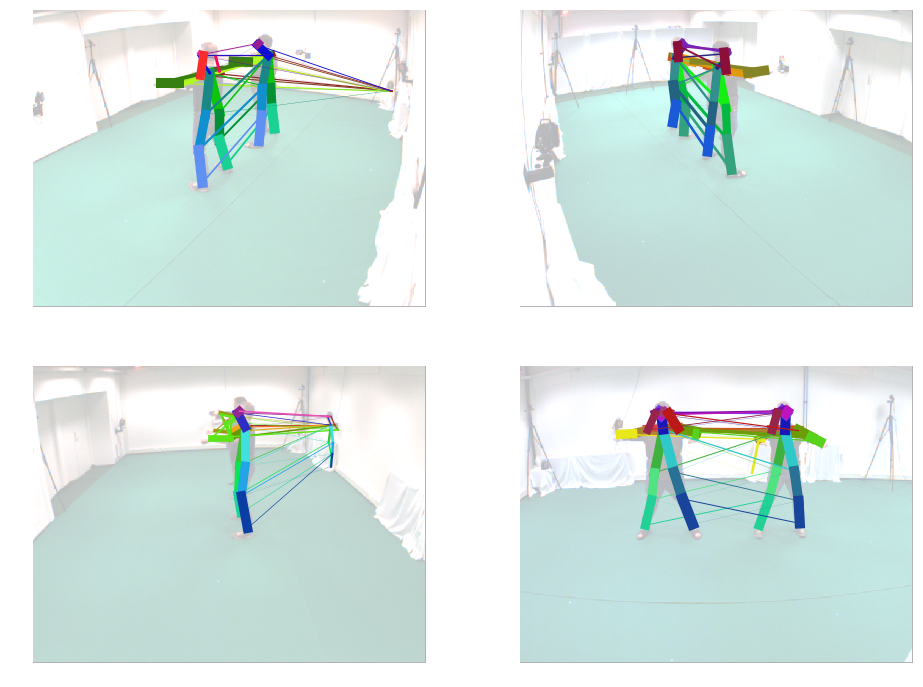

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
from mvpose.candidates import peaks as mvpeaks
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False



if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                _start = time()
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
                _end = time()
                print('elapsed:', _end - _start)
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []
Limb_Weights = []
Im_undist = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    im = Im[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    Limb_Weights.append(limbs)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    im_ud, K_new = gm.remove_distortion(im, cam)
    Im_undist.append(im_ud)
    h,w,_ = hm.shape
    mapx, mapy = \
        cv2.initUndistortRectifyMap(
            K, distCoef, None, K_new, (w, h), 5)
    peaks_undist = mvpeaks.Peaks.undistort(peaks, mapx, mapy)
    Peaks_undist.append(peaks_undist)
    
    assert peaks_undist.n_joints == peaks.n_joints
    for __k in range(peaks_undist.n_joints):
        p1 = peaks[__k]
        p2 = peaks_undist[__k]
        assert p1.shape == p2.shape, 'k:' + str(__k)
    
    Calib_undist.append({
        'K': K_new,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

2d:
	peaks1: (2, 3)
	peaks2: (2, 3)

3d:
	3d peaks: (4, 4)
elapsed 0.011113882064819336

n3d argmax:
	3d peaks: (2, 4)
	0 -> 0
	1 -> 1


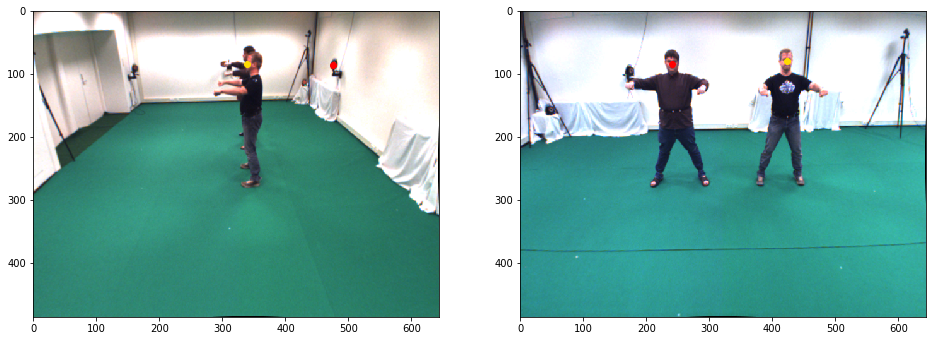

In [2]:
from cselect import color as cs

cam1 = 2; cam2 = 3
J = 0

K1, rvec1, tvec1, _ = gm.get_camera_parameters(Calib_undist[cam1])
peaks1 = Peaks_undist[cam1]
K2, rvec2, tvec2, _ = gm.get_camera_parameters(Calib_undist[cam2])
peaks2 = Peaks_undist[cam2]

print('2d:')
print('\tpeaks1:',peaks1[J].shape)
print('\tpeaks2:',peaks2[J].shape)

joints_3d, idx_pairs = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)

print('\n3d:')
print('\t3d peaks:', joints_3d[J].shape)


# ------------

_start = time()
pts3d, idx_pairs = stereo.triangulate_argmax(
    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
_end = time()
print('elapsed', _end - _start)

print('\nn3d argmax:')
print('\t3d peaks:', pts3d[J].shape)
for a,b in idx_pairs[J]:
    print('\t' + str(a) + ' -> ' + str(b))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot figure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121); ax.imshow(Im_undist[cam1])
ay = fig.add_subplot(122); ay.imshow(Im_undist[cam2])

COLOR1 = cs.lincolor(8)/255
COLOR2 = cs.lincolor(8)/255

for idx, (x,y,score) in enumerate(peaks1[J]):
    ax.scatter(x,y, color=COLOR1[idx])

for idx, (x,y,score) in enumerate(peaks2[J]):
    ay.scatter(x,y, color=COLOR2[idx])

elapsed 0.2281970977783203


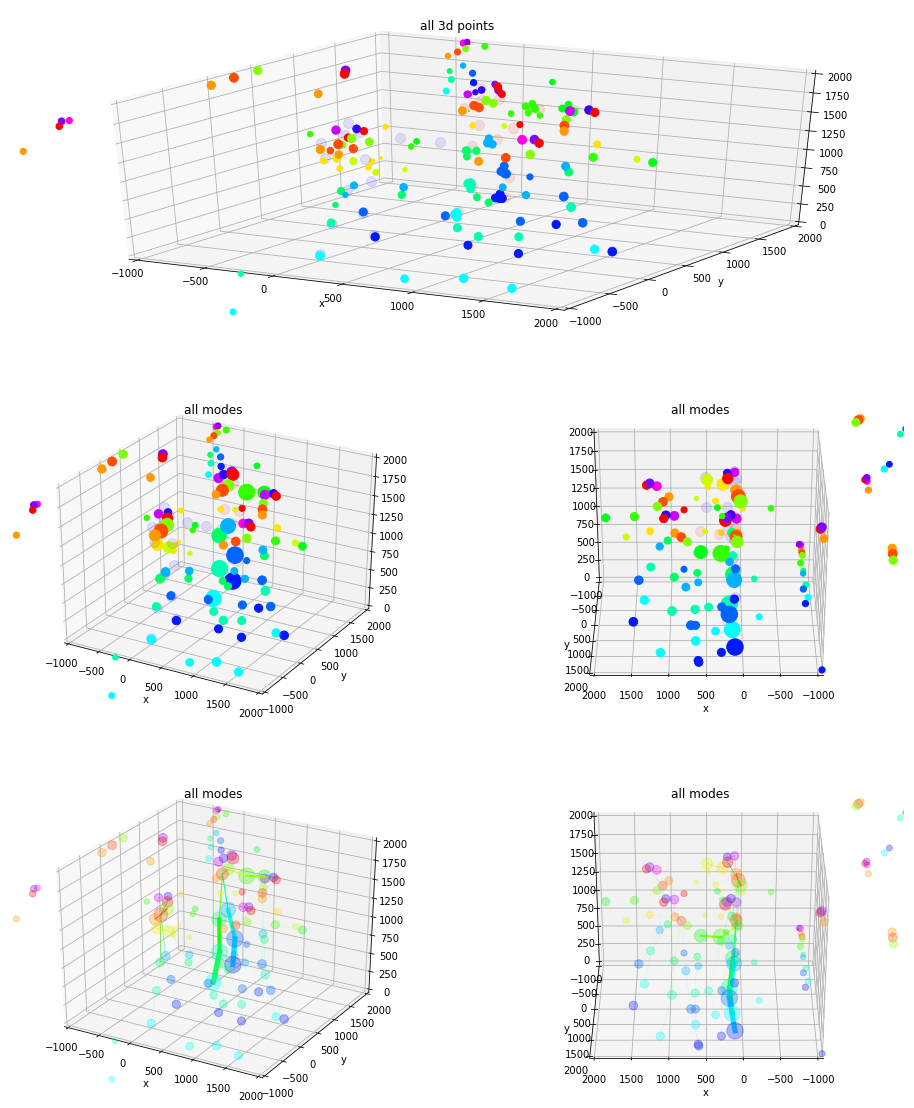

In [3]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH
# from mvpose.algorithm.meanshift import find_all_modes
# import numpy.linalg as la
# from cselect import color as cs
# from scipy.optimize import linear_sum_assignment

from mvpose.candidates.candidates import Candidates
        
        
# ======================================================
                

_start = time()
cand = Candidates(Peaks_undist, Limb_Weights, Calib_undist, r=200, mode_between_distance=50)
_end = time()
print('elapsed', _end - _start)

# --- plot all points ---

JOINT = 3

def set_cage(ax):
    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('x');  ax.set_ylabel('y')

points3d = cand.points3d

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d'); set_cage(ax)
ax.set_title('all 3d points')

COLORS = cs.lincolor(len(points3d) + 3)/255
for k, P in enumerate(points3d):
    ax.scatter(P[:,0],P[:,1],P[:,2], color=COLORS[k], s=P[:,3]*100, alpha=1)


# ~~~~~~~ only modes ~~~~~~~
modes = cand.modes3d
ay1 = fig.add_subplot(323, projection='3d'); set_cage(ay1)
ay2 = fig.add_subplot(324, projection='3d'); set_cage(ay2); ay2.view_init(30, 90); 

def plt_mode(ay, alpha=1):
    ay.set_title('all modes')

    COLORS = cs.lincolor(len(modes) + 3)/255
    for k, P in enumerate(modes):
        if len(P[0]) > 0:
            ay.scatter(P[0][:,0],P[0][:,1],P[0][:,2], s=P[0][:,3]*100, color=COLORS[k], alpha=alpha)


plt_mode(ay1)
plt_mode(ay2)
            
# ---- plot ground truth ---
color = ['red', 'blue']
for x,y,z,pid in Y[FRAME]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)
    ay1.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)
    ay2.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)

    
# ---- plot weights ---
def plot_weights(ax, candidate):
    modes = candidate.modes3d
    COLORS = cs.lincolor(len(DEFAULT_LIMB_SEQ) + 3)/255
    for lid, (k1, k2) in enumerate(DEFAULT_LIMB_SEQ):
        
        W = candidate.mode_limbs[lid]
        n, m = W.shape
        
        pts1, _ = modes[k1]
        pts2, _ = modes[k2]
        assert len(pts1) == n
        assert len(pts2) == m
        
        for u, (x1,y1,z1,w1) in enumerate(pts1):
            for v, (x2,y2,z2,w2) in enumerate(pts2):
                w = max(0, W[u,v])
                ax.plot([x1,x2], [y1,y2], [z1,z2], 
                       color=COLORS[lid], linewidth=w/100, alpha=0.9)
        


ax = fig.add_subplot(325, projection='3d'); set_cage(ax)
plt_mode(ax, alpha=0.3)
plot_weights(ax, cand)

ax = fig.add_subplot(326, projection='3d'); set_cage(ax); ax.view_init(30, 90); 

plt_mode(ax, alpha=0.3)
plot_weights(ax, cand)

    
plt.show()

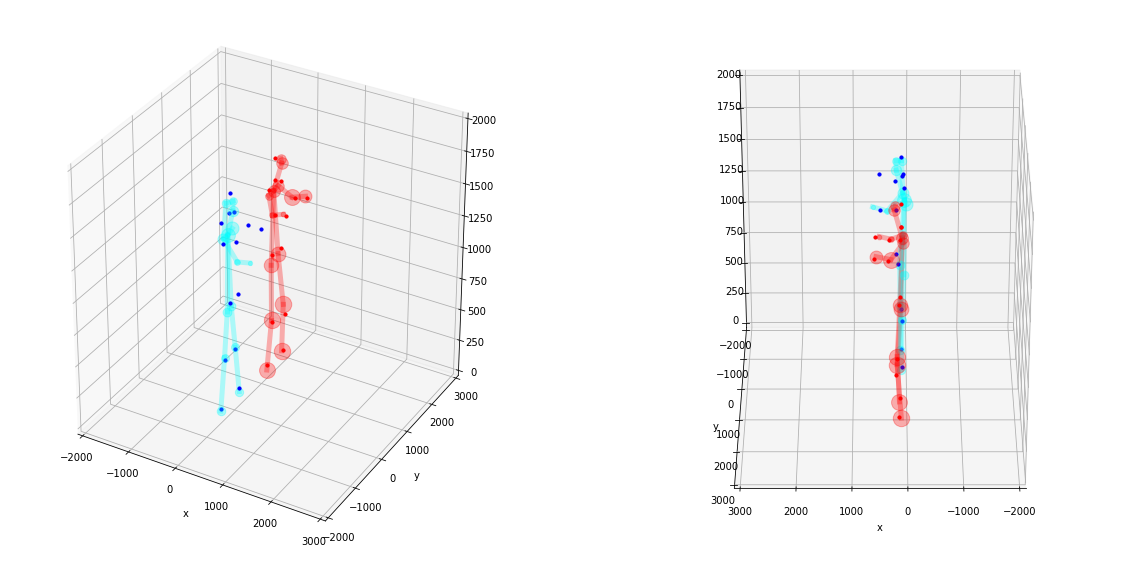

In [5]:
from mvpose.plot.skeleton import generate3d
from mvpose.pose import estimate

humans = estimate(Calib, heatmaps, pafs)

def do_all(ax):
    ax.set_xlim([-2000, 3000])
    ax.set_ylim([-2000, 3000])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('x');  ax.set_ylabel('y')

    humans = cand.humans

    COLORS = cs.lincolor(len(humans.keys()) + 1)/255

    for idx, (key, human) in enumerate(humans.items()):
        
        for p in human['joints']:
            if p is not None:
                x,y,z,w = p
                ax.scatter(x,y,z, color=COLORS[idx], s=w*100, alpha=0.3)

        generate3d(ax, human['joints'], DEFAULT_LIMB_SEQ, COLORS[idx], alpha=0.3)


    color = ['red', 'blue']
    for x,y,z,pid in Y[FRAME]:
        ax.scatter([x],[y],[z], color=color[int(pid)], alpha=1, s=10)
        

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
do_all(ax)

ax = fig.add_subplot(122, projection='3d'); ax.view_init(30, 90); 
do_all(ax)
    
plt.show()